# Create a raster mask using a shapefile

**What does this notebook do?** 

This notebook demonstrates how to use a shapefile to mask data extracted from DEA. This notebook imports some Landsat 8 data, generates a shapefile mask, and applies it to the extracted Landsat data.

**Required inputs**

* A shape file containing the polygon you would like to use for the analysis. Here we use the ACT reserves [shapefile from data.gov.au](http://actmapi-actgov.opendata.arcgis.com/datasets/df2194f3f13f4521a96c15a0faba04ee_11).

This example uses two external functions called `three_band_image` and `load_nbarx`. These functions are available in the Scripts folder of the [dea-notebooks Github repository](https://github.com/GeoscienceAustralia/dea-notebooks/tree/master/Scripts). Note that these functions have been developed by DEA users, not the DEA development team, and so are provided without warranty. If you find an error or bug in the functions, please either create an 'Issue' in the Github repository, or fix it yourself and create a 'Pull' request to contribute the updated function back into the repository (See the repository [README](https://github.com/GeoscienceAustralia/dea-notebooks/blob/master/README.rst) for instructions on creating a Pull request).

**Date:** May 2018

**Author:** Claire Krause

In [1]:
%pylab notebook

from datacube import Datacube

import xarray as xr
import rasterio
import rasterio.features
import geopandas as gp

# Import the custom scripts. These can be found in the dea-notebooks repository.
import sys
import os.path
sys.path.append(os.path.expanduser('~/dea-notebooks/Scripts'))
import DEAPlotting
import DEADataHandling

dc = Datacube(app='raster mask')

Populating the interactive namespace from numpy and matplotlib


## Set up the extraction query

In [2]:
query = {'lat': (-35.25, -35.35),
         'lon': (149.05, 149.17),
         'time': ('2016-01-01', '2016-03-01')
         }

In [3]:
data, crs, affine = DEADataHandling.load_nbarx(dc, 'ls8', query,
                                               bands_of_interest=['swir1', 'nir', 'green'])

Loading ls8_nbart_albers
Loaded ls8_nbart_albers
Generating mask ls8_pq_albers
Masked ls8_nbart_albers with ls8_pq_albers and filtered terrain


## Read in the shapefile you would like to use to mask the Landsat data

For this example, we use the polygon dataset of [ACT Reserves](http://actmapi-actgov.opendata.arcgis.com/datasets/df2194f3f13f4521a96c15a0faba04ee_11). 

In [4]:
shape_file = os.path.expanduser('~/dea-notebooks/Scripts/ACT_Reserves.shp')

In [5]:
shp = gp.read_file(shape_file)

# Reproject coordinate system of shape file
shp = shp.to_crs({'init': 'epsg:3577'})

I am densified (external_values, 167 elements)


### Iterate over each of the polygons, and put a '1' in the mask raster that corresponds to the footprint of each polygon

In [6]:
mask = rasterio.features.rasterize(((feature['geometry'], 1) for feature in shp.iterfeatures()),
                                   out_shape=data.isel(time=0).green.shape,
                                   transform=data.green.affine
                                  )

In [7]:
# Convert the numpy array to a DataArray
mask = xr.DataArray(mask, coords=(data.y, data.x))

<IPython.core.display.Javascript object>


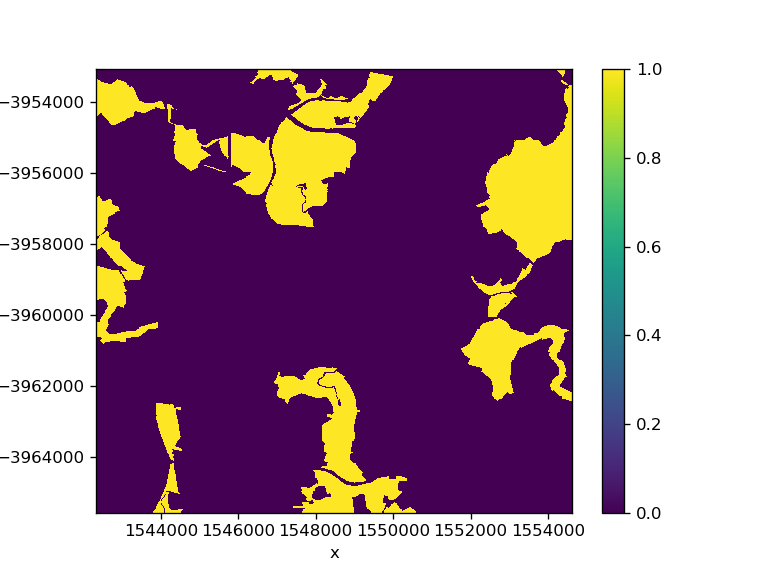

In [8]:
plt.figure()
mask.plot()

## Apply the mask to the Landsat data and plot

In [9]:
# Data * mask = data or nan
MaskedData = data.where(mask)

<IPython.core.display.Javascript object>


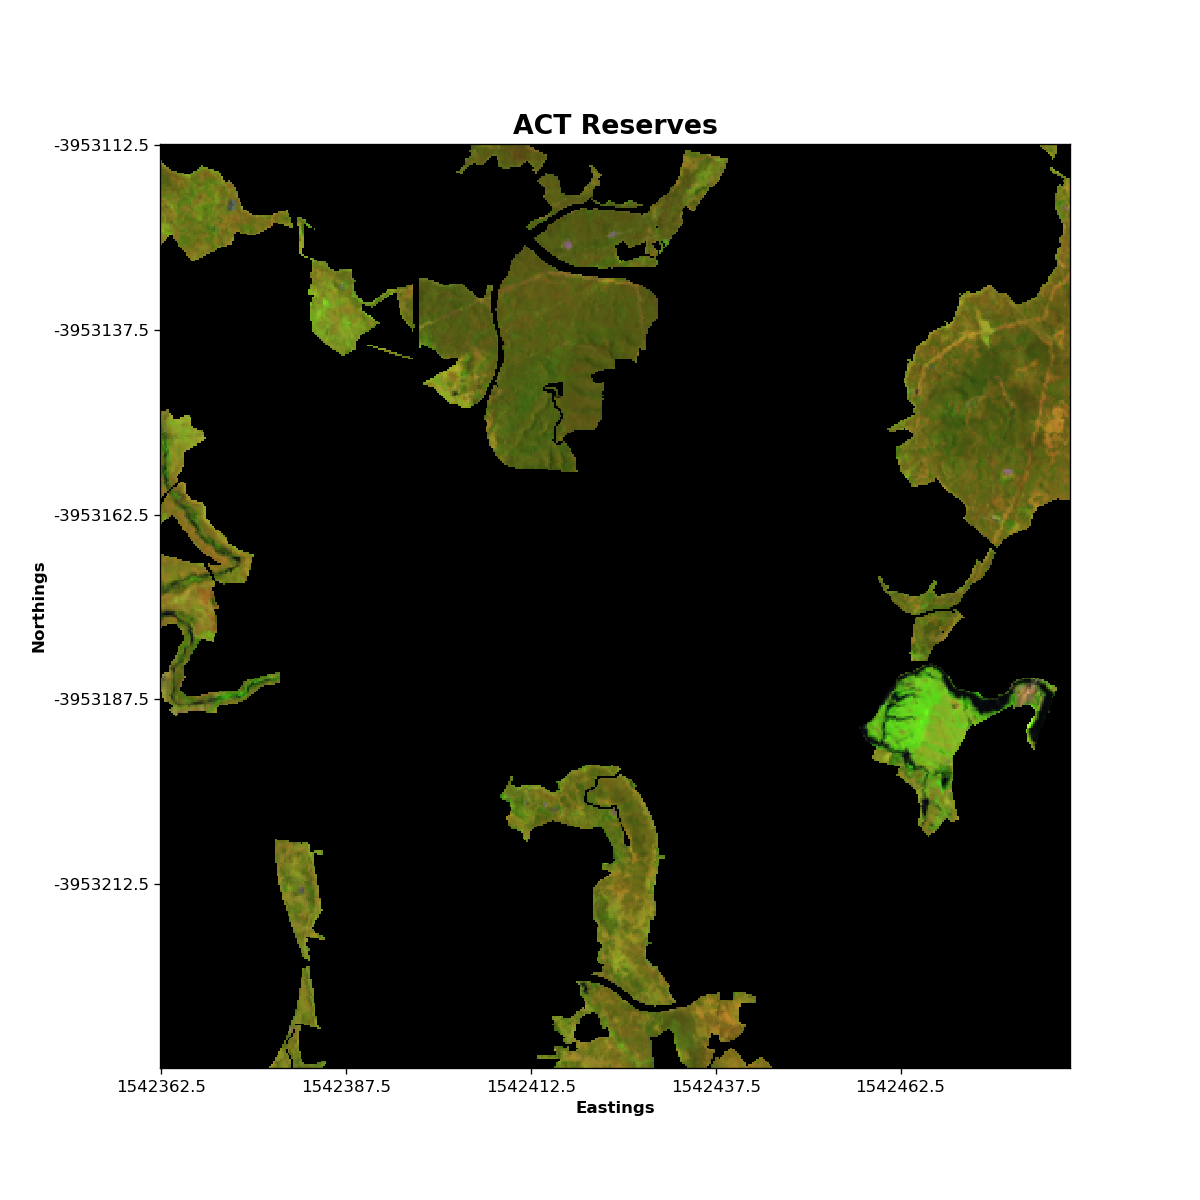

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


In [10]:
DEAPlotting.three_band_image(MaskedData, bands = ['swir1', 'nir', 'green'], time = 5, title = 'ACT Reserves');